# Image Stiching Using RANSAC

In [1]:
import math
import random
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
from scipy.spatial.distance import cdist
from skimage.transform import warp, ProjectiveTransform

## Preprocessing

In [2]:
# OpenCV imread stores images in B,G,R order
# Matplotlib imread stores images in R,G,B order
bolivia_l = plt.imread('bolivia3.jpg')
bolivia_m = plt.imread('bolivia2.jpg')
bolivia_r = plt.imread('bolivia1.jpg')

bolivia_l_grey = cv.cvtColor(bolivia_l, cv.COLOR_RGB2GRAY)
bolivia_m_grey = cv.cvtColor(bolivia_m, cv.COLOR_RGB2GRAY)
bolivia_r_grey = cv.cvtColor(bolivia_r, cv.COLOR_RGB2GRAY)

# Convert colour images to float to make combining easier
bolivia_l = bolivia_l / 255
bolivia_m = bolivia_m / 255
bolivia_r = bolivia_r / 255

## Detect Keypoints and Extract Descriptors

In [3]:
def detect_keypoints(img, sift = cv.SIFT_create(), subset = 'all'):
    # use a mask to prevent detection of keypoints in a portion of the image
    # this allows us to reduce the number of keypoints significantly (e.g. by half)
    r, c = img.shape[:2]
    mask =  np.ones((r,c), dtype='uint8') * 255
    if subset == 'left':
        split = img.shape[1] // 2
        mask[:,split:] = mask[:,split:] * 0
    elif subset == 'right':
        split = img.shape[1] // 2
        mask[:,:split] = mask[:,:split] * 0
    kp, des = sift.detectAndCompute(img, mask=mask)
    return kp, des

def show_keypoints(img, kp):
    # OpenCV drawKeypoints overwrites the input image
    # Just give it an empty array to work with
    tmp = np.zeros(img.shape)
    tmp = cv.drawKeypoints(img, kp, tmp, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    plt.imshow(tmp)

In [4]:
b_sift = cv.SIFT_create(edgeThreshold = 10, contrastThreshold = 0.05)

b_kp_l, b_des_l = detect_keypoints(bolivia_l_grey, sift=b_sift)
b_kp_m, b_des_m = detect_keypoints(bolivia_m_grey, sift=b_sift)
b_kp_r, b_des_r = detect_keypoints(bolivia_r_grey, sift=b_sift)

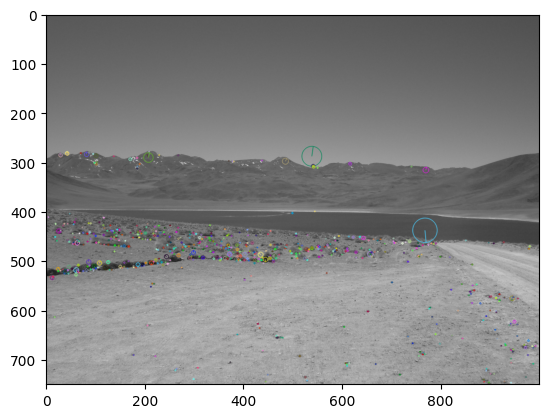

In [5]:
show_keypoints(bolivia_l_grey, b_kp_l)

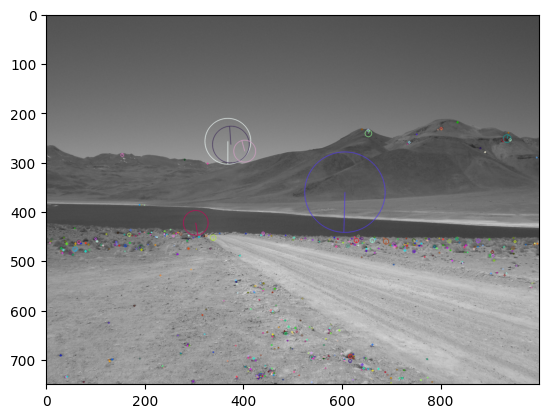

In [6]:
show_keypoints(bolivia_m_grey, b_kp_m)

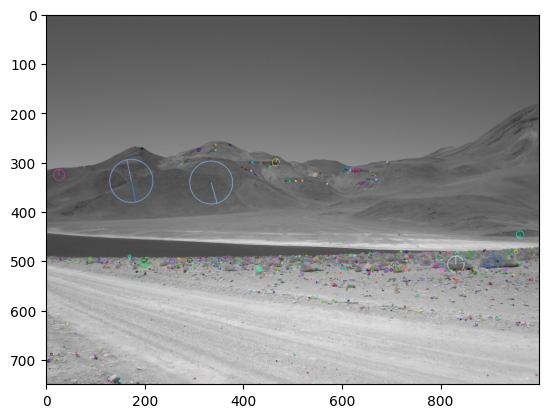

In [7]:
show_keypoints(bolivia_r_grey, b_kp_r)

## Match and Prune Features

In [8]:
def match_features(kp_l, des_l, kp_r, des_r):
    distances = cdist(des_l, des_r, metric='sqeuclidean')
    min_index = np.argmin(distances, axis=1)
    n = len(kp_l)
    matches = np.zeros(shape=(n, 5), dtype=int)
    for i in range(n):
        j = min_index[i]
        matches[i, 0] = distances[i, j]
        # pt attribute stores pair as (x, y)
        matches[i, 1], matches[i, 2] = kp_l[i].pt
        matches[i, 3], matches[i, 4] = kp_r[j].pt
    return matches

def prune(matches, threshold):
    mask = (matches[:, 0] < threshold)
    matches = matches[mask, :]
    matches = np.delete(matches, 0, axis=1)
    return matches

def plot_inlier_matches(ax, img1, img2, inliers):
    """
    Plot the matches between two images according to the matched keypoints
    :param ax: plot handle
    :param img1: left image
    :param img2: right image
    :inliers: x,y in the first image and x,y in the second image (Nx4)
    """
    # This line assumes img1 and img2 have the same number of rows
    res = np.hstack([img1, img2])
    ax.set_aspect('equal')
    ax.imshow(res, cmap='gray')
    
    ax.plot(inliers[:,0], inliers[:,1], '+r')
    ax.plot(inliers[:,2] + img1.shape[1], inliers[:,3], '+r')
    ax.plot([inliers[:,0], inliers[:,2] + img1.shape[1]],
            [inliers[:,1], inliers[:,3]], 'r', linewidth=0.4)
    ax.axis('off')

def plot_inlier_fix(ax, img1, img2, inliers):    
    img1_r, img1_c = img1.shape[:2]
    img2_r, img2_c = img2.shape[:2]
    if img1_r > img2_r:
        padding = np.zeros(shape=((img1_r - img2_r), img2_c))
        img2 = np.vstack([img2, padding])
    elif img1_r < img2_r:
        padding = np.zeros(shape=((img2_r - img1_r), img1_c))
        img1 = np.vstack([img1, padding])
    plot_inlier_matches(ax, img1, img2, inliers)

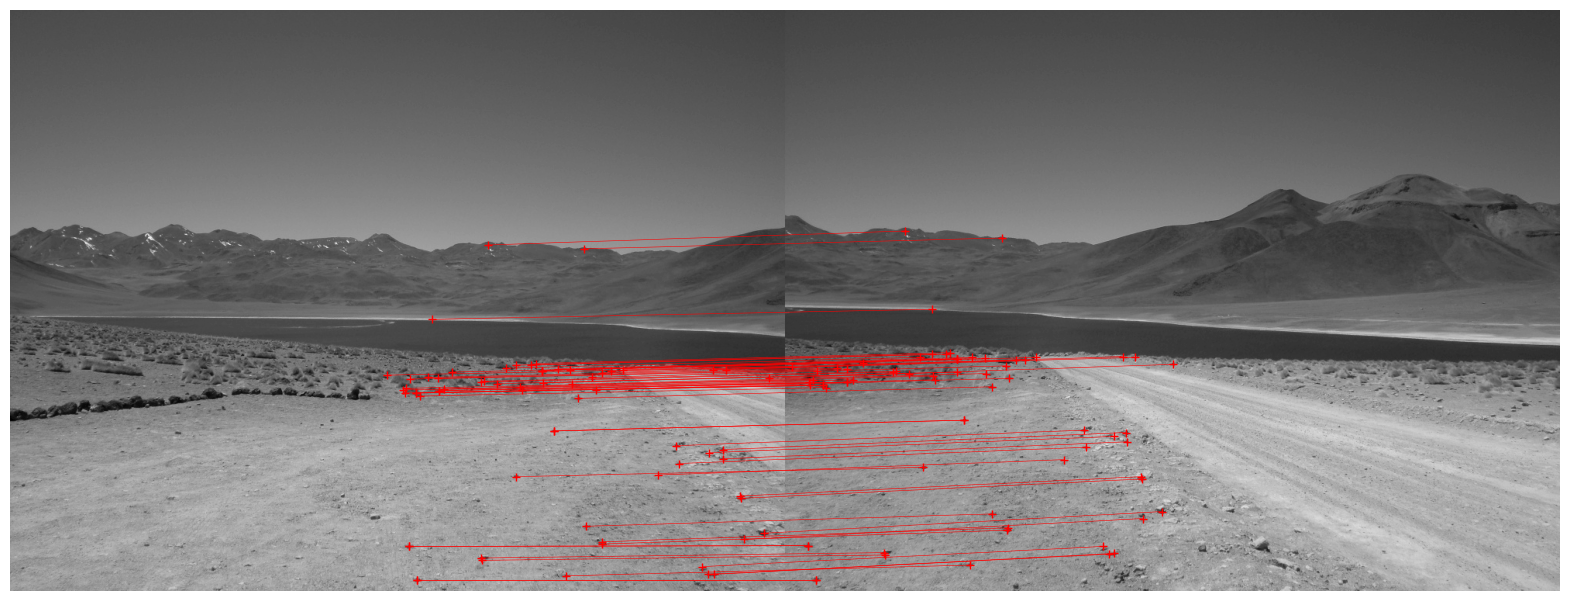

In [9]:
b_match_lm = match_features(b_kp_l, b_des_l, b_kp_m, b_des_m)
b_match_lm = prune(b_match_lm, threshold=10000)

fig, ax = plt.subplots(figsize=(20,10))
plot_inlier_fix(ax, bolivia_l_grey, bolivia_m_grey, b_match_lm)

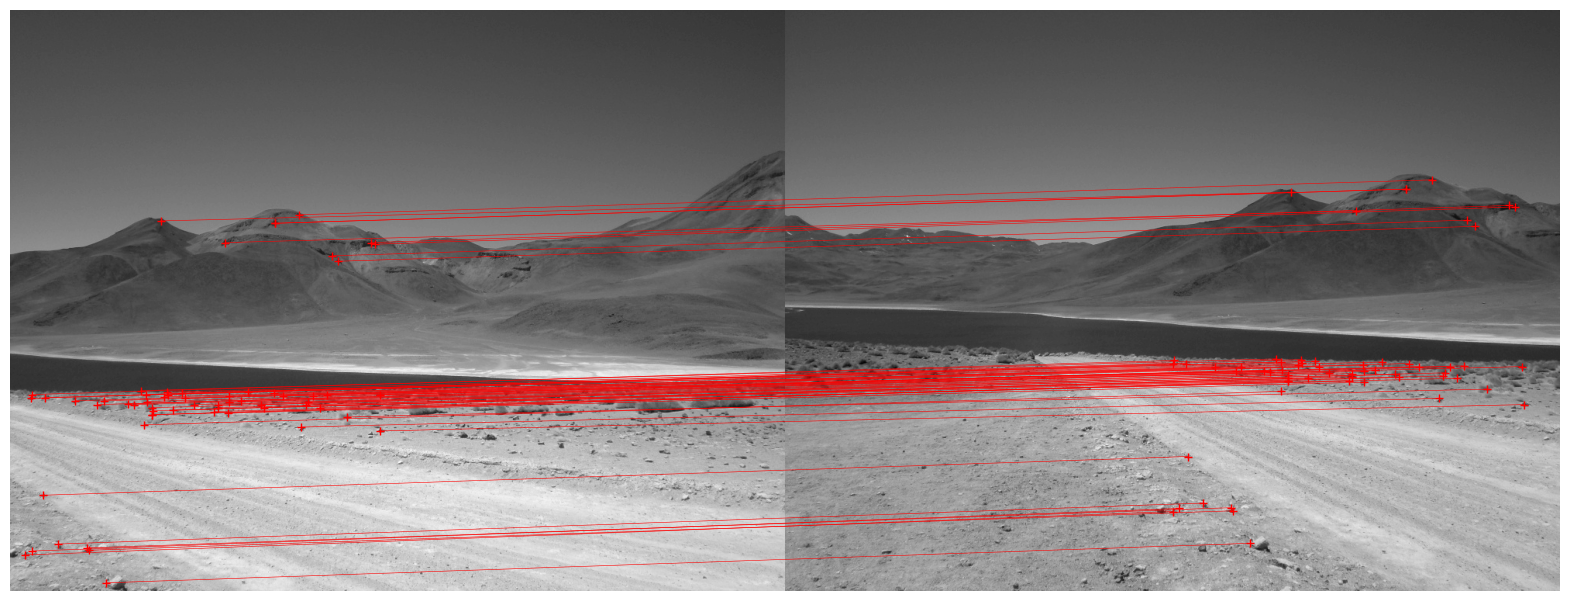

In [10]:
b_match_rm = match_features(b_kp_r, b_des_r, b_kp_m, b_des_m)
b_match_rm = prune(b_match_rm, threshold=10000)

fig, ax = plt.subplots(figsize=(20,10))
plot_inlier_fix(ax, bolivia_r_grey, bolivia_m_grey, b_match_rm)

## RANSAC

We can represent the affine transformation as follows:
$$
\begin{bmatrix} x' \\ y' \end{bmatrix} 
=
\begin{bmatrix} a & b \\ d & e \end{bmatrix}
\begin{bmatrix} x \\ y \end{bmatrix}
+
\begin{bmatrix} c \\ f \end{bmatrix}
=
\begin{bmatrix} ax + by + c \\ dx + ey + f \end{bmatrix}
=
\begin{bmatrix} x & y & 1 & 0 & 0 & 0 \\ 0 & 0 & 0 & x & y & 1 \end{bmatrix}
\begin{bmatrix} a \\ b \\ c \\ d \\ e \\ f \end{bmatrix}
$$

We require **a minimum of 3 pairs** of (x,y) points to solve for the 6 free parameters.
$$
\mathbf{b}
=
\begin{bmatrix} x_1' \\ y_1' \\ x_2' \\ y_2' \\ x_3' \\ y_3' \end{bmatrix}
=
\begin{bmatrix} 
x_1 & y_1 & 1 & 0 & 0 & 0 
\\ 0 & 0 & 0 & x_1 & y_1 & 1
\\ x_2 & y_2 & 1 & 0 & 0 & 0 
\\ 0 & 0 & 0 & x_2 & y_2 & 1 
\\ x_3 & y_3 & 1 & 0 & 0 & 0 
\\ 0 & 0 & 0 & x_3 & y_3 & 1 
\end{bmatrix}
\begin{bmatrix} a \\ b \\ c \\ d \\ e \\ f \end{bmatrix}
=
\mathbf{A} \mathbf{x}
$$
$$
\mathbf{x}
=
\begin{bmatrix} a \\ b \\ c \\ d \\ e \\ f \end{bmatrix}
= \mathbf{A}^{-1} \mathbf{b}
$$

In [11]:
def estimate_affine_3pt(pair1, pair2, pair3):
    x1, y1, x1_prime, y1_prime = pair1
    x2, y2, x2_prime, y2_prime = pair2
    x3, y3, x3_prime, y3_prime = pair3
    A = np.array([
        [x1, y1, 1, 0, 0, 0],
        [0, 0, 0, x1, y1, 1],
        [x2, y2, 1, 0, 0, 0],
        [0, 0, 0, x2, y2, 1],
        [x3, y3, 1, 0, 0, 0],
        [0, 0, 0, x3, y3, 1]
    ])
    b = np.array([x1_prime, y1_prime, x2_prime, y2_prime, x3_prime, y3_prime])
    return np.matmul(np.linalg.inv(A), b.T).reshape((2,3))

def apply_homography_1pt(x, y, H):
    x_in = np.array([x, y, 1])
    x_out = np.matmul(H, x_in.T)
    x_prime = x_out[0] / x_out[2]
    y_prime = x_out[1] / x_out[2]
    return x_prime, y_prime

def apply_affine(X, A):
    H = np.vstack([A, np.array([0,0,1])])
    return apply_homography(X, H)

def apply_homography(X, H):
    n = X.shape[0]
    X = np.hstack([X, np.ones(shape=(n,1))])
    X_prime = np.matmul(H, X.T)
    # X_prime is the transpose of what we want, so we divide rows
    X_prime[0] = X_prime[0] / X_prime[2]
    X_prime[1] = X_prime[1] / X_prime[2]
    X_prime = np.delete(X_prime, 2, axis=0)
    return X_prime.T

def get_inliers(matches, T, rho=10, func=apply_affine):
    input = matches[:,:2]
    expected = matches[:,2:]
    estimated = func(input, T)
    r = np.linalg.norm(estimated - expected, axis=1)
    return r < rho

def ransac_affine(matches, n=20, rho=10):
    indices = list(range(matches.shape[0]))
    inliers = np.zeros(matches.shape[0])
    for i in range(n):
        i, j, k = random.sample(indices, 3)
        p1 = matches[i]
        p2 = matches[j]
        p3 = matches[k]
        T = estimate_affine_3pt(p1, p2, p3)
        new_inliers = get_inliers(matches, T, rho=rho, func=apply_affine)
        if np.sum(new_inliers) >= np.sum(inliers):
            inliers = new_inliers    
    return matches[inliers]

def estimate_affine_ls(inliers):
    n = inliers.shape[0]
    x = inliers[:,0]
    y = inliers[:,1]
    b = inliers[:,2:].reshape(-1)
    A = np.zeros((n,12))
    A[:,0] = x
    A[:,1] = y
    A[:,2] = 1
    A[:,-3] = x
    A[:,-2] = y
    A[:,-1] = 1
    A = A.reshape(2*n,6)
    AT_A = np.matmul(A.T, A)
    pseduo_inv = np.matmul(np.linalg.inv(AT_A), A.T)
    return np.matmul(pseduo_inv, b).reshape((2,3))

def estimate_homography(inliers):
    n = inliers.shape[0]
    x = inliers[:,0]
    y = inliers[:,1]
    xp = inliers[:,2]
    yp = inliers[:,3]
    A = np.zeros((n,18))
    A[:,0] = x
    A[:,1] = y
    A[:,2] = 1
    A[:,6] = -1 * x * xp
    A[:,7] = -1 * y * xp
    A[:,8] = -1 * xp
    A[:,12] = x
    A[:,13] = y
    A[:,14] = 1
    A[:,15] = -1 * x * yp
    A[:,16] = -1 * y * yp
    A[:,17] = -1 * yp
    A = A.reshape(2*n,9)
    
    U, S, V = np.linalg.svd(A)
    
    return V[-1].reshape(3,3)

def ransac_homography(matches, n=20, rho=10):
    indices = list(range(matches.shape[0]))
    inliers = np.zeros(matches.shape[0])
    for i in range(n):
        i, j, k, m = random.sample(indices, 4)
        p1 = matches[i]
        p2 = matches[j]
        p3 = matches[k]
        p4 = matches[m]
        pts = np.vstack([p1, p2, p3, p4])
        T = estimate_homography(pts)
        new_inliers = get_inliers(matches, T, rho=rho, func=apply_homography)
        if np.sum(new_inliers) >= np.sum(inliers):
            inliers = new_inliers    
    return matches[inliers]

In [12]:
inliers_b_lm = ransac_homography(b_match_lm, n=1000, rho=3)
inliers_b_rm = ransac_homography(b_match_rm, n=1000, rho=3)

In [13]:
H_b_lm = estimate_homography(inliers_b_lm)
H_b_rm = estimate_homography(inliers_b_rm)

# convert homography from right image to left image coordinates
H_b_rm_inv = np.linalg.inv(H_b_rm)
H_b_rl = np.matmul(H_b_lm, H_b_rm_inv)

## Create Panorama

In [14]:
def combine_images(left, right, H):
    H_inv = np.linalg.inv(H)
    y_max1, x_max1 = left.shape[:2]
    y_max2, x_max2 = right.shape[:2]
    # compute max dimension of right image in coordinates of left image
    x_max2, y_max2 = apply_homography_1pt(x_max2, y_max2, H_inv)
    x_max = math.ceil(max(x_max1, x_max2))
    y_max = math.ceil(max(y_max1, y_max2))

    output = warp(right, ProjectiveTransform(matrix=H), output_shape=(y_max,x_max))

    output_overlap = output[:y_max1, :x_max1]
    output_overlap = np.maximum.reduce([left, output_overlap])
    output[:y_max1, :x_max1] = output_overlap
    return output

In [15]:
bolivia_lm = combine_images(bolivia_l, bolivia_m, H_b_lm)
bolivia = combine_images(bolivia_lm, bolivia_r, H_b_rl)

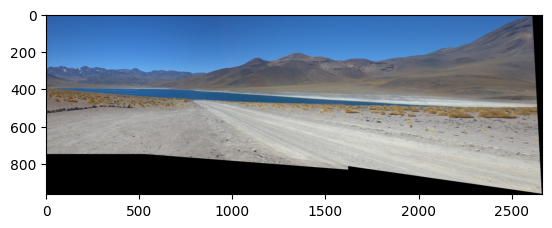

In [16]:
plt.imshow(bolivia)

In [17]:
plt.imsave('bolivia_stiched.jpg', bolivia)